In [1]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

In [2]:
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [6]:
series_original = mean_monthly_temp['Deg']

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


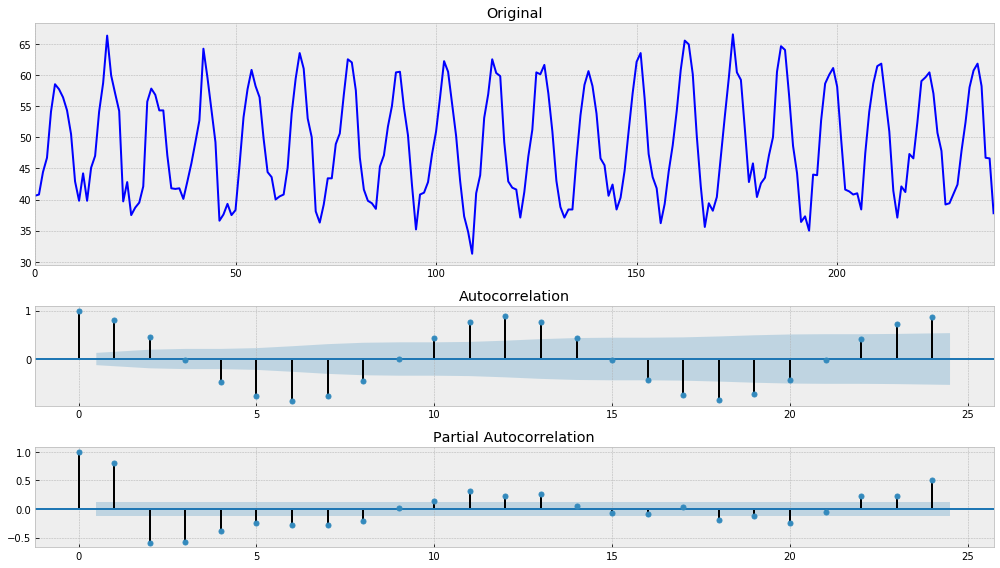

In [7]:
tsplot(series_original)

Тест Дики-Фуллера и графики коррелограмм показывают, что ряд не стационарный и в нем наблюдается сезонность
Преобразуем ряд к стационарному, для этого уберем изменение дисперсии, проведем дифференцирование и у берем влияние сезонности.

In [8]:
series_change = boxcox(series_original, 0)
series_change = series_change[1:] - series_change[:-1]
series_change = series_change[12:] - series_change[:-12]

Results of Dickey-Fuller Test:
Test Statistic                -7.999033e+00
p-value                        2.361164e-12
#Lags Used                     1.500000e+01
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64


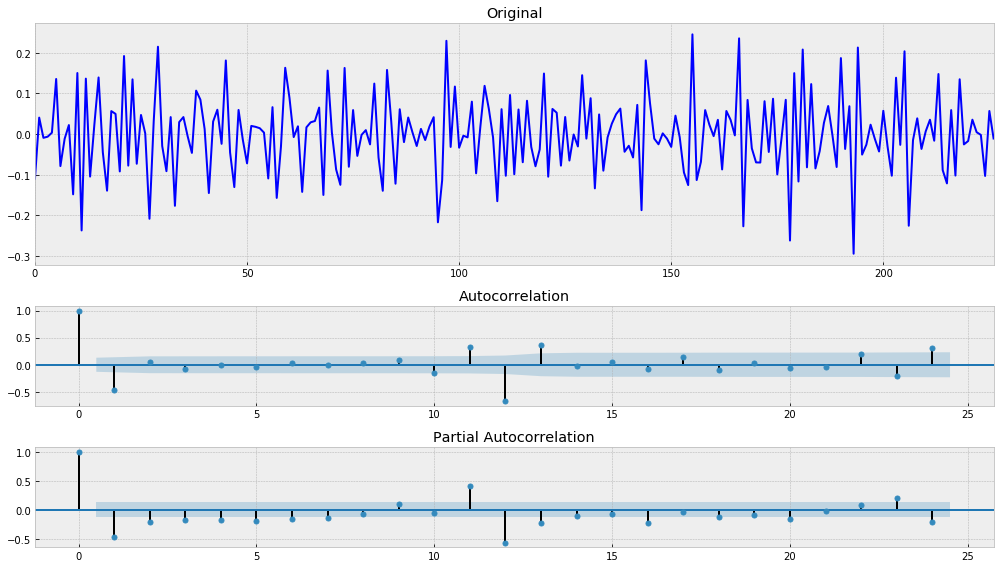

In [9]:
tsplot(series_change)

In [10]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

На оригинальном ряду будем использовать тройное экспоненциальное сглаживание, т.к в нем присутствует сезонность, а tema учитывает сезонность

In [11]:
def initial_trend(series, season_len):
    return sum([float(series[0 + season_len] - series[0]) / season_len]) / season_len

In [12]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [13]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [14]:
def plot_tema(alpha, beta, gamma, ser=mean_monthly_temp['Deg'], ser_to_plot=mean_monthly_temp['Deg'], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [15]:
series_original.shape

(240,)

Разбиваем на тестовую и валидационную выборку и делаем кросс-валидацию

In [16]:
train, val = series_original[:150], series_original[150:]

In [17]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [18]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [19]:
print(opt)

      fun: 2.27704242077617e-08
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.66400144e-05, -4.81828755e-05,  7.73807193e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 460
      nit: 85
   status: 0
  success: True
        x: array([0.04042851, 0.26585909, 0.97420254])


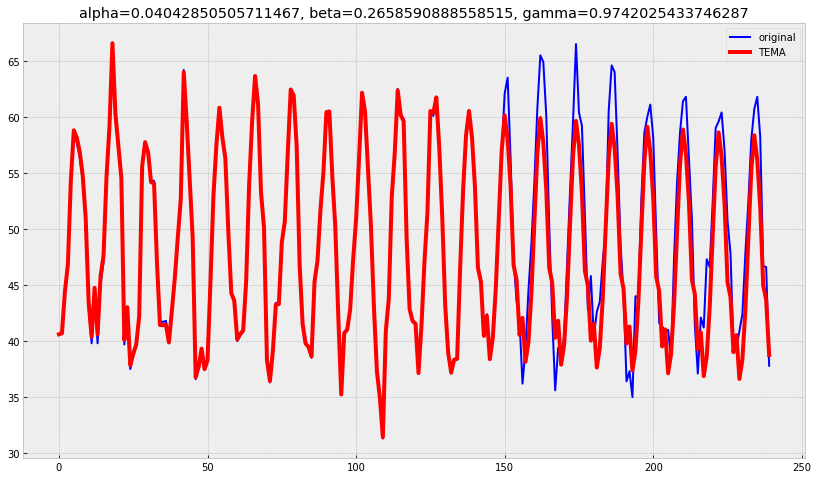

In [20]:
alpha_opt, beta_opt, gamma_opt = opt.x
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series_original, n_preds=len(val))

Для стационарного рядя выберем dema, т.к там влияние сезонности, там незначительное

In [21]:
series_change.shape

(227,)

In [22]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [23]:
def plot_dema(alpha, beta):
    dema = double_ema(series_change, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series_change, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [24]:
train, test, val = series_change[:150], series_change[150:160], series_change[160:]

In [25]:
def mse_c(X):
    alpha, beta = X
    result = double_ema(train, alpha, beta)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error
    

In [34]:
opt = minimize(mse_c, x0=[0,0], bounds = ((0, 1), (0, 1)))

In [35]:
alpha, beta= opt.x

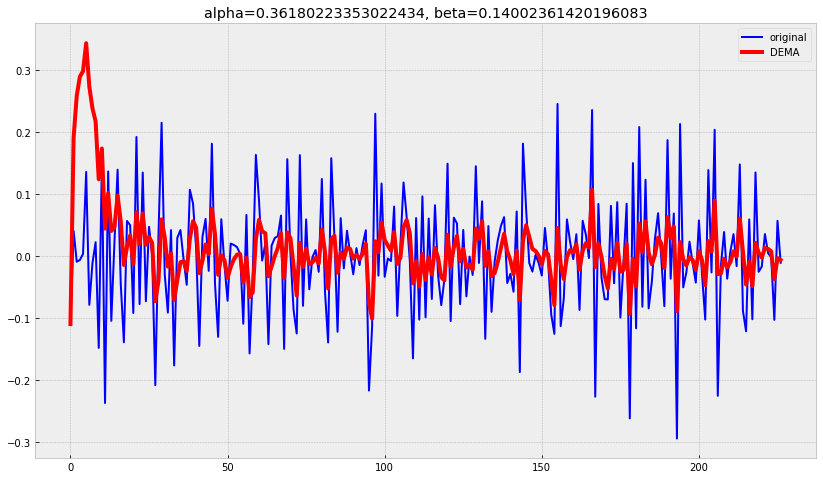

In [36]:
plot_dema(alpha, beta)